In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# Calculate rheological prefactor

In [4]:
# reference conditions for the upper mantle
depth_ref  = 20e3 # m
temp_ref   = 495
R = 8.314

cr_yr = 0.05 #m/yr
yr = 365*24*60*60
cr = cr_yr/yr #m/s
shear_d = 2000 #m

strain_ref = cr/shear_d

Esed = 125e3
Vsed = 0
nsed = 4     
Ecrust = 482e3
Vcrust = 0
ncrust = 4.7

adiabat = 0.3; # K/km
temp_ref   = temp_ref + (depth_ref * 1e-3 * adiabat)
press_ref  = 2900. * 9.81 * depth_ref


visc_sed = 1e20
visc_crust = 1e21
rho_sed = 2700
rho_crust = 2900
sed = 2e3
crust = 7.5e3

visc = (visc_sed*sed + visc_crust*crust)/(sed+crust)
rho = (rho_sed*sed + rho_crust*crust)/(sed+crust)
drho = (3300-rho)

n = (nsed*sed + ncrust*crust)/(sed+crust)
E = (Esed*sed + Ecrust*crust)/(sed+crust)
h = 9.5e3

Aeq = ((2*visc)**(-1. * n)) / (  (strain_ref**(n-1)) * np.exp(-(E)/(R*temp_ref))  )
visc_check_crust = (1/2)*Aeq**(-1/n) * strain_ref**((1-n)/n) * np.exp((E)/(n*R*temp_ref))
print("crust prefactor = %e. Check: %e = %e" % (Aeq,visc,visc_check_crust))

################# SEDIMENTS ####################
Ased = ((2*visc_sed)**(-1. * nsed)) / (  strain_ref**(nsed-1) * np.exp(-(Esed+press_ref*Vsed)/(R*temp_ref))  )
visc_check_sed = (1/2)*Ased**(-1/nsed) * strain_ref**((1-nsed)/nsed) * np.exp((Esed+press_ref*Vsed)/(nsed*R*temp_ref))
print("sediments prefactor = %e. Check: %e = %e" % (Ased,visc_sed,visc_check_sed))


################# CRUST ####################
Acrust = ((2*visc_crust)**(-1. * ncrust)) / (  strain_ref**(ncrust-1) * np.exp(-(Ecrust+press_ref*Vcrust)/(R*temp_ref))  )
visc_check_crust = (1/2)*Acrust**(-1/ncrust) * strain_ref**((1-ncrust)/ncrust) * np.exp((Ecrust+press_ref*Vcrust)/(ncrust*R*temp_ref))
print("crust prefactor = %e. Check: %e = %e" % (Acrust,visc_crust,visc_check_crust))


crust prefactor = 7.058740e-12. Check: 8.105263e+20 = 8.105263e+20
sediments prefactor = 1.353771e-32. Check: 1.000000e+20 = 1.000000e+20
crust prefactor = 8.200986e-06. Check: 1.000000e+21 = 1.000000e+21


# Calculate missing parameter for rheology

In [5]:
Ts = 615 #kelvin, sediments
Tc = 560 #kelvin, crust
to = 16e6 #tau(y=0); Pa
g = 9.81 #m/s2
dip = np.radians(30) #dip, rad
drc = 3300-rho_crust #drho of crust, kg/m3
drs = 3300-rho_sed #drho of sediment, kg/m3

Pc = drc*np.sin(dip)*g #buoy crust
Ps = drs*np.sin(dip)*g #buoy sediment

Sexp = np.exp(Esed/(R*Ts))
Cexp = np.exp(Ecrust/(R*Tc))

# fs = np.sqrt(3)**(nsed+1)
# fc = np.sqrt(3)**(ncrust+1)

Cs = (Sexp/(2*Ased))**(1/nsed)
Cc = (Cexp/(2*Acrust))**(1/ncrust)


gc = (to/(Pc*crust)) + 1
gs = gc*((Pc*crust)/(Ps*sed)) +1

gc, gs

(2.08732585796806, 6.2183146449201505)

# Calculate velocities

In [15]:
ys = np.linspace(7.5e3, 9.5e3, 200)
yc = np.linspace(0.e3, 7.5e3, 800)
y = np.concatenate([yc,ys])
hi = 7.5e3
vs = (1/(nsed+1)) * ((Ps/Cs)**nsed) * ( ((sed*(gs +1) - ys)**(nsed+1)) - ((sed*gs - crust)**(nsed+1)) )
vi = (1/(nsed+1)) * ((Ps/Cs)**nsed) * ( ((sed*(gs +1) - hi)**(nsed+1)) - ((sed*gs - crust)**(nsed+1)) )
# vc = vi + ( (1/(ncrust+1)) * ((Pc/Cc)**ncrust) * ( (crust*(gc+1) - yc)**(ncrust+1) - (crust*gc)**(ncrust+1) ) )

# vsl = vi + ( (1/(ncrust+1)) * ((Pc/Cc)**ncrust) * ( (crust*(gc+1))**(ncrust+1) - (crust*gc)**(ncrust+1) ) )
vsl = np.array([6, 3, 1, 0.2])*1e-2/yr
vi = vsl - ( (1/(ncrust+1)) * ((Pc/Cc)**ncrust) * ( (crust*(gc+1))**(ncrust+1) - (crust*gc)**(ncrust+1) ) )
vc = np.zeros((len(vsl), len(yc)))
vs = np.zeros((len(vsl), len(ys)))
v = np.zeros((len(vsl), len(y)))

In [16]:
for i in range(len(vsl)):
    # vc[i] = vsl[i] * ( ((vsl[i] - vi[i])/vsl[i])*((pow((gc+1 - yc/crust),(ncrust+1)) - pow(gc, (ncrust+1))) / (pow((gc+1),(ncrust+1)) - pow(gc, (ncrust+1)))) + vi[i]/vsl[i])
    vc[i] = ( ((vsl[i] - vi[i]))*((pow((gc+1 - yc/crust),(ncrust+1)) - pow(gc, (ncrust+1))) / (pow((gc+1),(ncrust+1)) - pow(gc, (ncrust+1)))) + vi[i])
    vs[i] = vi[i]*( (pow((gs+1-ys/sed),(nsed+1)) - pow((gs - crust/sed),(nsed+1))) / (pow((gs+1-crust/sed),(nsed+1)) - pow((gs - crust/sed),(nsed+1))) )

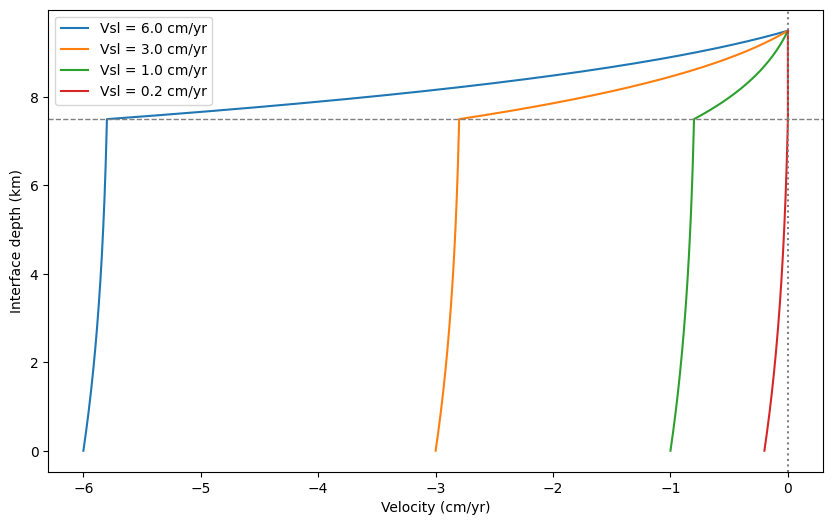

In [17]:
plt.figure(figsize=(10,6))
for i in range(len(vsl)):
    v[i] = np.concatenate([vc[i], vs[i]])

    plt.plot(-v[i]*yr*1e2, y/1e3, label=f"Vsl = {vsl[i]*yr*1e2} cm/yr")

plt.axvline(x = 0, linestyle = ':', color = "grey")
plt.legend()
plt.xlabel("Velocity (cm/yr)")
plt.axhline(y = 7.5, color="grey", linestyle = "--", linewidth = 1)
plt.ylabel("Interface depth (km)")
plt.savefig("vel_prof.png" , dpi = 1000)



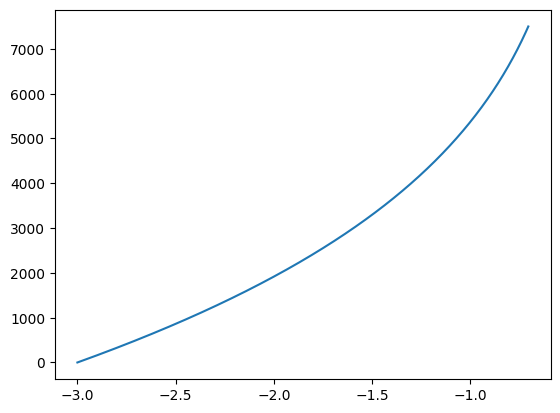

In [48]:
plt.plot(-vc*1e2*yr, yc)
# plt.scatter(vc[0]*1e2*yr, yc[0])
# print(vc[0]*1e2*yr)

### Plot sediment velocity

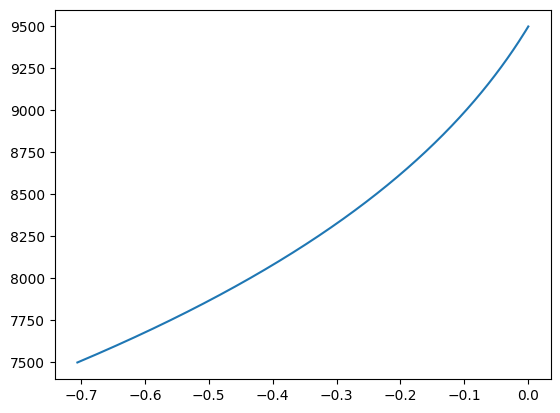

In [49]:
plt.plot(-vs*yr*1e2, ys)
# plt.axvline(x=0, "--")
# plt.scatter(vi,hi)

### Plot crust velocity

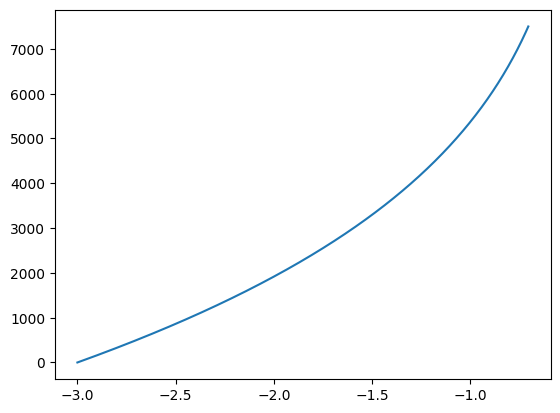

In [50]:
plt.plot(-vc*1e2*yr, yc)

### Plot both

Text(0, 0.5, 'Interface depth (km)')

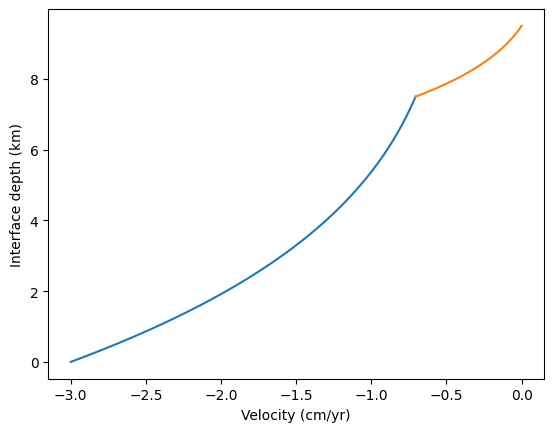

In [51]:
plt.plot(-vc*1e2*yr, yc/1e3, label="crust")
plt.plot(-vs*1e2*yr,ys/1e3, label="sediments")

plt.xlabel("Velocity (cm/yr)")
plt.ylabel("Interface depth (km)")